<a href="https://colab.research.google.com/github/juliakatsoulis/Portfolio/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing relevant packages and features
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import SplineTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Model V2!

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Attempt 1

Best Parameters and Metrics:
lr              0.010000
dropout_rate    0.200000
MSE             0.003979
MAE             0.049870
RMSE            0.063077
R2              0.859642
Name: 5, dtype: float64


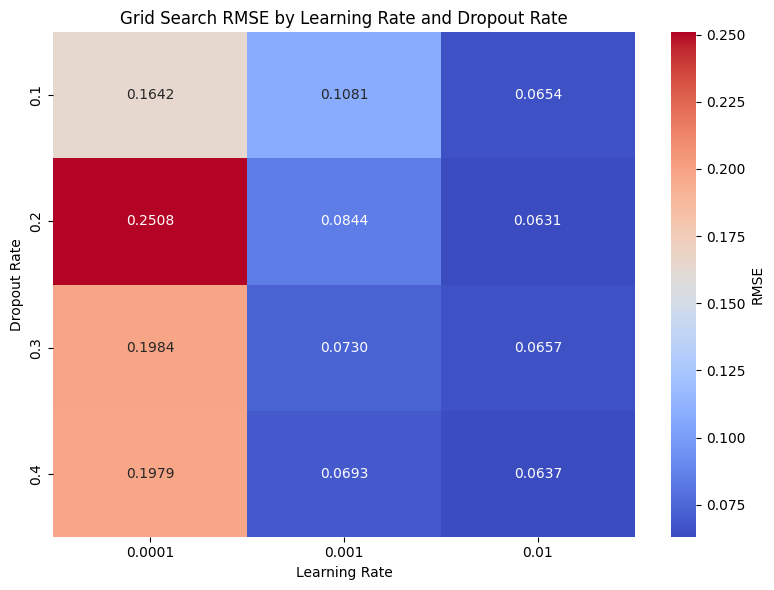

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

#Load data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BIG PROJECT FOLDER/cbb_three_year_data_good_variables.csv')
data['win_percentage'] = data['W'] / data['G']

#Define features and target
X = data.drop(columns=['win_percentage', 'W', 'WAB', 'Team', 'CONF'])
y = data['win_percentage']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#Define Neural Network with dropout
class Net(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.drop1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

#Train model
def train_model(model, X_train, y_train, X_val, y_val, lr, epochs=200):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val)
        mse = mean_squared_error(y_val, preds.numpy())
        mae = mean_absolute_error(y_val, preds.numpy())
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, preds.numpy())

    return mse, mae, rmse, r2, model

#Grid search
param_grid = {
    'lr': [1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4]
}

results = []
for params in ParameterGrid(param_grid):
    model = Net(input_dim=X_train_tensor.shape[1], dropout_rate=params['dropout_rate'])
    mse, mae, rmse, r2, trained_model = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, lr=params['lr'])

    results.append({
        'lr': params['lr'],
        'dropout_rate': params['dropout_rate'],
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

#Convert results to DataFrame
results_df = pd.DataFrame(results)
best_row = results_df.sort_values('RMSE').iloc[0]
print("Best Parameters and Metrics:")
print(best_row)
#Visualization
pivot_table = results_df.pivot(index="dropout_rate", columns="lr", values="RMSE")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
plt.title("Grid Search RMSE by Learning Rate and Dropout Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Dropout Rate")
plt.tight_layout()
plt.show()



# Attempt with graphs

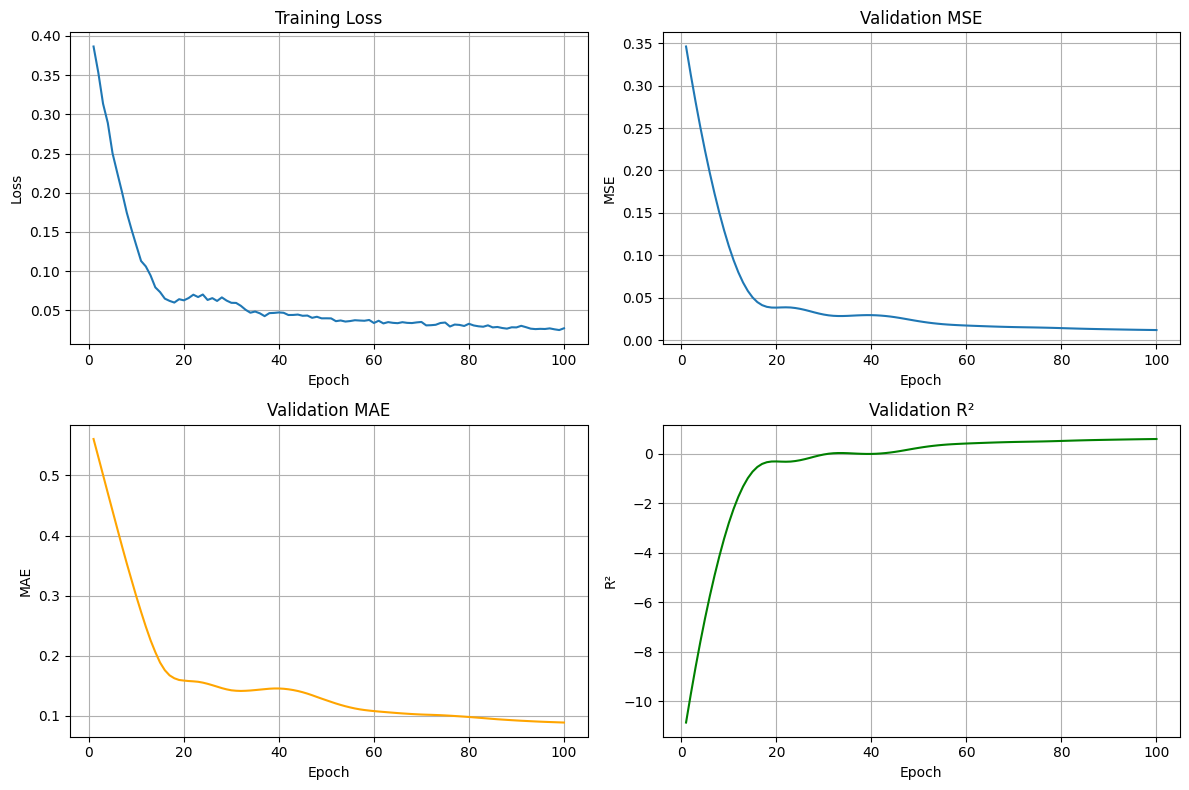

In [ ]:
import matplotlib.pyplot as plt

def train_model_track(model, X_train, y_train, X_val, y_val, lr, epochs=200):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_mse_list = []
    val_mae_list = []
    val_rmse_list = []
    val_r2_list = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        #Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            preds = val_output.numpy()
            y_val_np = y_val.numpy()

            val_mse = mean_squared_error(y_val_np, preds)
            val_mae = mean_absolute_error(y_val_np, preds)
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(y_val_np, preds)

            val_mse_list.append(val_mse)
            val_mae_list.append(val_mae)
            val_rmse_list.append(val_rmse)
            val_r2_list.append(val_r2)

    return {
        'train_loss': train_losses,
        'val_mse': val_mse_list,
        'val_mae': val_mae_list,
        'val_rmse': val_rmse_list,
        'val_r2': val_r2_list
    }

def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['train_loss']) + 1)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics_dict['train_loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics_dict['val_mse'], label='MSE')
    plt.title('Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics_dict['val_mae'], label='MAE', color='orange')
    plt.title('Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics_dict['val_r2'], label='R²', color='green')
    plt.title('Validation R²')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

model = Net(input_dim=X_train_tensor.shape[1], dropout_rate=0.2)
metrics = train_model_track(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, lr=0.001, epochs=100)
plot_metrics(metrics)


# Test feature importance

In [ ]:
import copy

def permutation_importance(model, X_val_tensor, y_val_tensor, metric_fn, feature_names, n_repeats=5):
    model.eval()
    baseline_preds = model(X_val_tensor).detach().numpy()
    baseline_score = metric_fn(y_val_tensor.numpy(), baseline_preds)

    importances = np.zeros(X_val_tensor.shape[1])

    for col in range(X_val_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_val_tensor.clone()
            idx = torch.randperm(X_permuted.size(0))
            X_permuted[:, col] = X_permuted[idx, col]

            permuted_preds = model(X_permuted).detach().numpy()
            permuted_score = metric_fn(y_val_tensor.numpy(), permuted_preds)

            #Higher score after shuffling = feature mattered
            scores.append(permuted_score - baseline_score)

        importances[col] = np.mean(scores)

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    return importance_df


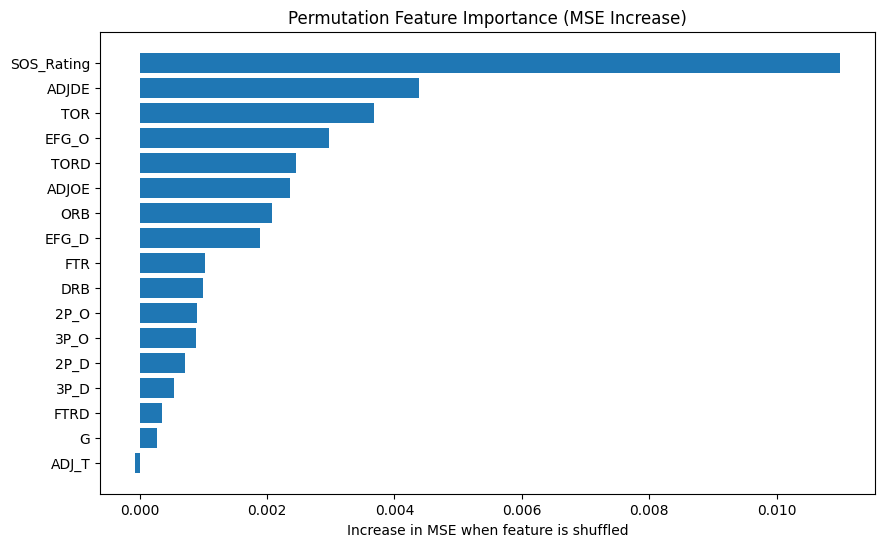

In [ ]:
#Assume model is already trained

feature_names = X.columns.tolist()

importance_df = permutation_importance(
    model=model,
    X_val_tensor=X_test_tensor,
    y_val_tensor=y_test_tensor,
    metric_fn=mean_squared_error,
    feature_names=feature_names,
    n_repeats=5  #More repeats = more stable
)

#Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Permutation Feature Importance (MSE Increase)')
plt.xlabel('Increase in MSE when feature is shuffled')
plt.show()
